<a href="https://colab.research.google.com/github/kotech1/computervision/blob/master/12_deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

실습 파일: `12-deepfake.ipynb`

# Variational autoencoder

In [ ]:
!pip install --upgrade gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.12.2-cp36-none-any.whl size=9694 sha256=e46c399f44bba44c7a4663fa00bc3cbc76b6d8b33b438b322766028abc371636
  Stored in directory: /root/.cache/pip/wheels/81/d0/d7/d9983facc6f2775411803e0e2d30ebf98efbf2fc6e57701e09
Successfully built gdown
  Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive

Mounted at /content/gdrive


**CelebA dataset**  
공식 구글 드라이브가 사용용량으로 다운로드가 불가능한 경우가 있습니다.  
미러 링크 등을 이용하시면 됩니다.  


In [ ]:
import gdown
md5 = '00d2c5bc6d35e252742224ab0c1e8fcb'  
# official download link
url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM'
# mirror url
url = 'https://drive.google.com/uc?id=1vsObPMdbOQwysIb-XulliKXqRSKrw6Iq'
output = '/mydrive/img_align_celeba.zip'
gdown.cached_download(url, output, md5=md5)


Computing MD5: /mydrive/img_align_celeba.zip
MD5 matches: /mydrive/img_align_celeba.zip


'/mydrive/img_align_celeba.zip'

CelebA attribute data

In [ ]:
import gdown
md5 = '4414d5bdd90f37e4a8548c501e098835'  
# official download link
url = 'https://drive.google.com/uc?id=1epcRzi5e2IzuWhAMNaigYtyRhwUq72-2'
output = '/mydrive/list_attr_celeba.csv'
gdown.cached_download(url, output, md5=md5)

Computing MD5: /mydrive/list_attr_celeba.csv
MD5 matches: /mydrive/list_attr_celeba.csv


'/mydrive/list_attr_celeba.csv'

In [ ]:
!mkdir -p vae_data/celeb
!mkdir -p vae_data/weights

In [ ]:
!unzip /mydrive/img_align_celeba.zip -d vae_data/celeb

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: vae_data/celeb/img_align_celeba/197601.jpg  
 extracting: vae_data/celeb/img_align_celeba/197602.jpg  
 extracting: vae_data/celeb/img_align_celeba/197603.jpg  
 extracting: vae_data/celeb/img_align_celeba/197604.jpg  
 extracting: vae_data/celeb/img_align_celeba/197605.jpg  
 extracting: vae_data/celeb/img_align_celeba/197606.jpg  
 extracting: vae_data/celeb/img_align_celeba/197607.jpg  
 extracting: vae_data/celeb/img_align_celeba/197608.jpg  
 extracting: vae_data/celeb/img_align_celeba/197609.jpg  
 extracting: vae_data/celeb/img_align_celeba/197610.jpg  
 extracting: vae_data/celeb/img_align_celeba/197611.jpg  
 extracting: vae_data/celeb/img_align_celeba/197612.jpg  
 extracting: vae_data/celeb/img_align_celeba/197613.jpg  
 extracting: vae_data/celeb/img_align_celeba/197614.jpg  
 extracting: vae_data/celeb/img_align_celeba/197615.jpg  
 extracting: vae_data/celeb/img_align_celeba/197616.jpg  
 extracting: vae_data/celeb/img_alig

In [ ]:
!cp /mydrive/list_attr_celeba.csv vae_data/celeb

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
import os
from glob import glob

In [ ]:
SAVE_FOLDER = 'vae_data'
DATA_FOLDER = SAVE_FOLDER + '/celeb/'

INPUT_DIM = (128,128,3)
BATCH_SIZE = 32

filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*.jpg')))

NUM_IMAGES = len(filenames)

mode =  'build' #'load' #
#mode =  'load' 

**학습용 Data Generator**

In [ ]:
data_gen = ImageDataGenerator(rescale=1./255)

data_flow = data_gen.flow_from_directory(DATA_FOLDER
                                         , target_size = INPUT_DIM[:2]
                                         , batch_size = BATCH_SIZE
                                         , shuffle = True
                                         , class_mode = 'input'
                                         , subset = "training"
                                            )

Found 202599 images belonging to 1 classes.


**Sampling 레이어**  
standard normal distritubion인 $\epsilon$ 샘플링으로부터   
$\mu$와 $\sigma$의 정규분포를 생성하는 레이어  
$ N(\mu, \sigma) = \mu + \sigma N(0, 1) = \mu + \sigma\epsilon$  

In [ ]:
class Sampling(layers.Layer):
    """Uses (mu, log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mu, log_var = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mu + tf.exp(log_var/2) * epsilon

**Encoder 모델 정의**  
Latent space의 차원: 200

In [ ]:
z_dim = 200
r_loss_factor = 10000

encoder_input = keras.Input(shape=INPUT_DIM, name='encoder_input')
x = Conv2D(32, 3, strides=2, padding="same", name='encoder_conv_0')(encoder_input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_1')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_2')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_3')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
mu = Dense(z_dim, name='mu')(x)
log_var = Dense(z_dim, name='log_var')(x)
z = Sampling(name='encoder_output')([mu, log_var])
encoder = keras.Model(encoder_input, [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         encoder_conv_0[0][0]             
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

**Decoder 모델 정의**


In [ ]:
decoder_input = keras.Input(shape=(z_dim,), name='decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t0')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t1')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", name='decoder_conv_t2')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)
x = layers.Conv2DTranspose(3, 3, strides=2, padding="same", name='decoder_conv_t3')(x)
decoder_output = Activation('sigmoid')(x)
decoder = keras.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 200)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              823296    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_t0 (Conv2DTrans (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 64)        0   

**Variational Autoencoder 모델 정의**  
`keras.Model` 클래스를 상속받아서 새로 정의함

In [ ]:
class VAEModel(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        #self.r_loss_factor = r_loss_factor

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.square(data - reconstruction), axis = [1,2,3]
                #keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= r_loss_factor
            #reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_sum(kl_loss, axis=1)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": tf.reduce_mean(total_loss),
            "reconstruction_loss": tf.reduce_mean(reconstruction_loss),
            "kl_loss": tf.reduce_mean(kl_loss),
        }

    def call(self,inputs):
        latent = self.encoder(inputs)
        return self.decoder(latent)

In [ ]:
LEARNING_RATE = 0.0005
EPOCHS = 200
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

save_folder = os.path.join(SAVE_FOLDER, 'weights')

VAE = VAEModel(encoder, decoder)
VAE.compile(optimizer=keras.optimizers.Adam(lr=LEARNING_RATE))

In [ ]:
MODE = 'build'
#MODE = 'load'

if MODE == 'load':
    #ae = keras.models.load_model(save_folder, custom_objects={'r_loss': r_loss})
    VAE.load_weights(save_folder+'/'+'checkpoint')

**Train**

In [ ]:
def step_decay_schedule(initial_lr, decay_factor=0.5, step_size=1):
    '''
    Wrapper function to create a LearningRateScheduler with step decay schedule.
    '''
    def schedule(epoch):
        new_lr = initial_lr * (decay_factor ** np.floor(epoch/step_size))
        return new_lr

    return LearningRateScheduler(schedule)

checkpoint = ModelCheckpoint(save_folder+'/'+'checkpoint', save_weights_only = False, verbose=1)
lr_sched = step_decay_schedule(initial_lr=LEARNING_RATE, decay_factor=1, step_size=1)
callbacks_list = [checkpoint, lr_sched]

VAE.fit(
    data_flow,
    shuffle=True,
    epochs=EPOCHS,
    steps_per_epoch = NUM_IMAGES / BATCH_SIZE,
    callbacks=callbacks_list
)

Epoch 1/200
6331/6331 [============================>.] - ETA: 0s - loss: 242.3543 - reconstruction_loss: 182.4552 - kl_loss: 59.8992
Epoch 00001: saving model to vae_data/weights/checkpoint
6332/6331 [==============================] - 300s 47ms/step - loss: 242.3427 - reconstruction_loss: 182.4437 - kl_loss: 59.8990
Epoch 2/200
6332/6331 [==============================] - ETA: 0s - loss: 208.7124 - reconstruction_loss: 147.5027 - kl_loss: 61.2096
Epoch 00002: saving model to vae_data/weights/checkpoint
6332/6331 [==============================] - 284s 45ms/step - loss: 208.7102 - reconstruction_loss: 147.5006 - kl_loss: 61.2096
Epoch 3/200
6332/6331 [==============================] - ETA: 0s - loss: 204.5653 - reconstruction_loss: 143.5435 - kl_loss: 61.0217
Epoch 00003: saving model to vae_data/weights/checkpoint
6332/6331 [==============================] - 285s 45ms/step - loss: 204.5613 - reconstruction_loss: 143.5403 - kl_loss: 61.0209
Epoch 4/200
6331/6331 [=======================

학습이 완료된 모델 weights 저장

In [ ]:
x = np.random.rand(1,128,128,3)
VAE.predict(x)
VAE.save(save_folder)

In [ ]:
!mkdir -p /mydrive/vae
!cp -r vae_data/weights /mydrive/vae

미리 학습된 weights 다운로드

In [ ]:
md5 = '82988648466578e98420296086d29d73'  
# official download link
url = 'https://drive.google.com/uc?id=1gpWjNdU2ZXsmqKoJdau7TxA5idyInhs5'
output = 'vae_weights.tar.gz'
gdown.cached_download(url, output, md5=md5)


Computing MD5: vae_weights.tar.gz
MD5 matches: vae_weights.tar.gz


'vae_weights.tar.gz'

weights 압축 해제

In [ ]:
!tar xvzf vae_weights.tar.gz -C vae_data

weights/
weights/keras_metadata.pb
weights/checkpoint.data-00000-of-00001
weights/checkpoint.index
weights/variables/
weights/variables/variables.data-00000-of-00001
weights/variables/variables.index
weights/saved_model.pb
weights/checkpoint
weights/assets/


weights 로드

In [ ]:
VAE.load_weights(save_folder+'/'+'checkpoint')

## VAE 분석

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
import pandas as pd

vae = VAE


In [ ]:
DATA_FOLDER = './vae_data/celeb/'
IMAGE_FOLDER = './vae_data/celeb/img_align_celeba/'

In [ ]:
class ImageLabelLoader():
    def __init__(self, image_folder, target_size):
        self.image_folder = image_folder
        self.target_size = target_size

    def build(self, att, batch_size, label = None):

        data_gen = ImageDataGenerator(rescale=1./255)
        if label:
            data_flow = data_gen.flow_from_dataframe(
                att
                , self.image_folder
                , x_col='image_id'
                , y_col=label
                , target_size=self.target_size
                , class_mode='raw'
                , batch_size=batch_size
                , shuffle=True
            )
        else:
            data_flow = data_gen.flow_from_dataframe(
                att
                , self.image_folder
                , x_col='image_id'
                , target_size=self.target_size
                , class_mode='input'
                , batch_size=batch_size
                , shuffle=True
            )

        return data_flow

In [ ]:
INPUT_DIM = (128,128,3)

att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))

imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])

In [ ]:
att.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1


**이미지 복원**

Found 202599 validated image filenames.


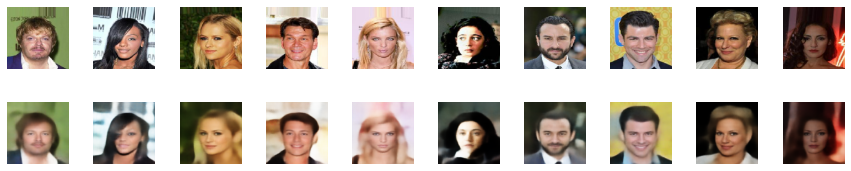

In [ ]:
n_to_show = 10

data_flow_generic = imageLoader.build(att, n_to_show)

example_batch = next(data_flow_generic)
example_images = example_batch[0]

_,_,z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)

**새로 얼굴 생성하기**

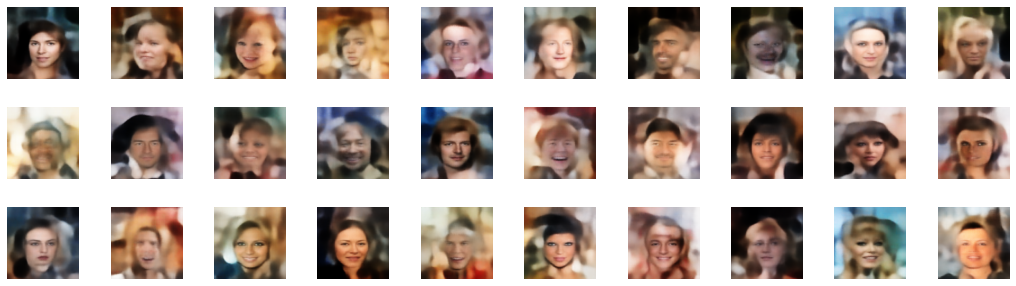

In [ ]:
z_dim = 200
n_to_show = 30

znew = np.random.normal(size = (n_to_show,z_dim))

reconst = vae.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.show()

In [ ]:
def get_vector_from_label(label, batch_size):

    data_flow_label = imageLoader.build(att, batch_size, label = label)

    origin = np.zeros(shape = z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        _,_,z = vae.encoder.predict(np.array(im))

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   

In [ ]:
def add_vector_to_images(feature_vec):

    n_to_show = 5
    factors = [-4,-3,-2,-1,0,1,2,3,4]

    example_batch = next(data_flow_generic)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    _,_,z_points = vae.encoder.predict(example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1

    plt.show()

In [ ]:
BATCH_SIZE = 500
# attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
# mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
# smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
# lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
# young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
# male_vec = get_vector_from_label('Male', BATCH_SIZE)
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)
# blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

Found 202599 validated image filenames.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
34    : 3.69    : 1.219    : 3.893    : 3.893
65    : 1.816    : 0.462    : 3.257    : -0.636
100    : 1.003    : 0.25    : 3.083    : -0.174
120    : 0.597    : 0.202    : 2.997    : -0.086
154    : 0.614    : 0.132    : 2.82    : -0.177
186    : 0.532    : 0.121    : 2.8    : -0.021
219    : 0.392    : 0.102    : 2.797    : -0.002
249    : 0.37    : 0.083    : 2.757    : -0.04
287    : 0.308    : 0.08    : 2.736    : -0.021
311    : 0.25    : 0.069    : 2.709    : -0.027
345    : 0.224    : 0.064    : 2.697    : -0.013
376    : 0.222    : 0.057    : 2.692    : -0.005
401    : 0.178    : 0.053    : 2.661    : -0.031
428    : 0.186    : 0.047    : 2.642    : -0.019
463    : 0.206    : 0.044    : 2.662    : 0.02
511    : 0.208    : 0.038    : 2.621    : -0.042
548    : 0.173    : 0.037    : 2.62    : -0.001
580    : 0.161    : 0.039    : 2.599    : -0.021
623    : 0.165    : 0.0

Eyeglasses Vector


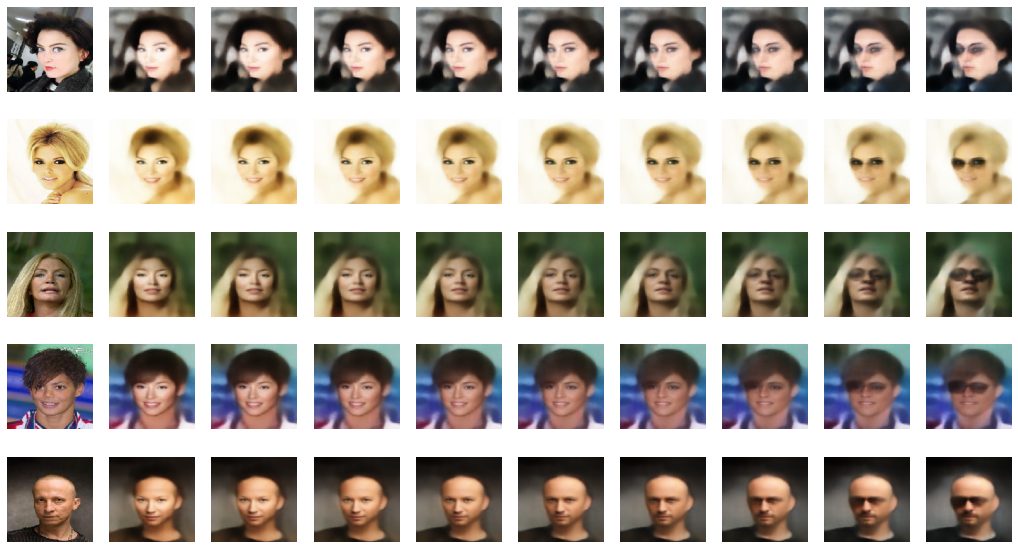

In [ ]:
# print('Attractive Vector')
# add_vector_to_images(attractive_vec)

# print('Mouth Open Vector')
# add_vector_to_images(mouth_open_vec)

# print('Smiling Vector')
# add_vector_to_images(smiling_vec)

# print('Lipstick Vector')
# add_vector_to_images(lipstick_vec)

# print('Young Vector')
# add_vector_to_images(young_vec)

# print('Male Vector')
# add_vector_to_images(male_vec)

print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

# print('Blond Vector')
# add_vector_to_images(blonde_vec)

In [ ]:
def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.1)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    _,_,z_points = vae.encoder.predict(example_images)


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)


    plt.show()

Found 2 validated image filenames.


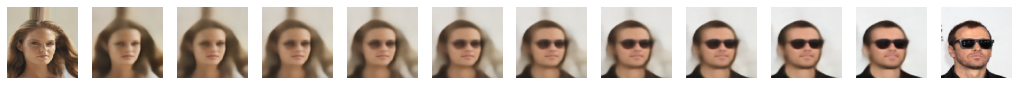

In [ ]:
start_image_file = '000238.jpg' 
end_image_file = '000193.jpg' #glasses

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


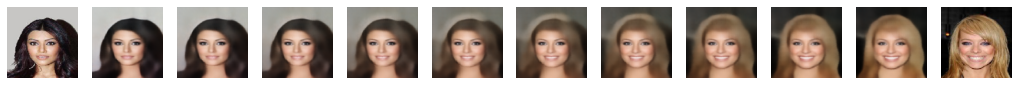

In [ ]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


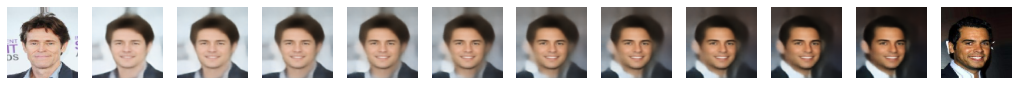

In [ ]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)

# Face swapping

In [1]:
!git clone -b tensorflow2.update --single-branch https://github.com/shevious/DeepFake_FaceSwap.git --depth=1

Cloning into 'DeepFake_FaceSwap'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 65 (delta 6), reused 49 (delta 2), pack-reused 0
Unpacking objects: 100% (65/65), done.


In [2]:
%cd DeepFake_FaceSwap

/content/DeepFake_FaceSwap


In [25]:
!mkdir -p obama-cut
!mkdir -p clinton-cut

In [4]:
!pip install face_recognition

     |████████████████████████████████| 100.2MB 75kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566173 sha256=f2a4fd6eaac09a92d9d1570ee96ec9e09d7aa46fa6d5d224fa017d915b6497da
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [5]:
import cv2
from pathlib import Path
import face_recognition
from lib_1.PluginLoader import PluginLoader
from lib_1.faces_detect import detect_faces
from lib_1.FaceFilter import FaceFilter
import os

In [29]:
input_directory="obama-jpg"
output_directory="obama-cut"
filter_file = 'filter/obamafilter.jpg'

In [7]:
def load_filter():
    #filter_file = '../content/filter/obamafilter.jpg' # TODO Change argument here depending on what youre trying to extract
    if os.path.exists(filter_file):
        print('Loading reference image for filtering')
        return FaceFilter(filter_file)
    else:
        print("Filter not detected")

def get_faces(image):
    faces_count = 0
    filterDeepFake = load_filter()

    for face in detect_faces(image):

        if filterDeepFake is not None and not filterDeepFake.check(face):
            print('Skipping not recognized face!')
            continue


        yield faces_count, face

In [9]:

from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

extractor_name = "Align" # TODO Pass as argument
extractor = PluginLoader.get_extractor(extractor_name)()

Loading Extract from Extract_Align plugin...


**얼굴 이미지 추출**

In [30]:
"""

#Single Example test

example  ="../content/data/CR_2012.jpg"


image = cv2.imread(example)

for idx, face in get_faces(image):
           resized_image = extractor.extract(image, face, 256)
           output_file = output_directory+"/"+str(Path(example).stem)
           cv2.imwrite(str(output_file) + str(idx) + Path(example).suffix, resized_image)
"""
#Simply iterating over the folder is insufficient, imread needs paths, so create them into a list.


def find_all_files(directory):
    for root, dirs, files in os.walk(directory):

        for file in files:
            p=os.path.join(root, file)
            p=p.split("/")[len(p.split("/"))-2]
            name, ext = os.path.splitext(p)

            yield os.path.join(root, file)
folder_img = find_all_files(input_directory)

try:
    for filename in folder_img:
        image = cv2.imread(filename)
        print(filename)
        for idx, face in get_faces(image):
            print('extractor')
            resized_image = extractor.extract(image, face, 256)
            output_file = output_directory+"/"+str(Path(filename).stem)
            print('imwrite')
            cv2.imwrite(str(output_file) + str(idx) + Path(filename).suffix, resized_image)

except Exception as e:
    print('Failed to extract from image: {}. Reason: {}'.format(filename, e))

input_directory="clinton-jpg"
output_directory="clinton-cut"
filter_file = 'filter/clintonfilter.jpg'

try:
    for filename in folder_img:
        image = cv2.imread(filename)
        print(filename)
        for idx, face in get_faces(image):
            print('extractor')
            resized_image = extractor.extract(image, face, 256)
            output_file = output_directory+"/"+str(Path(filename).stem)
            print('imwrite')
            cv2.imwrite(str(output_file) + str(idx) + Path(filename).suffix, resized_image)

except Exception as e:
    print('Failed to extract from image: {}. Reason: {}'.format(filename, e))

obama-jpg/159.jpg
Loading reference image for filtering
-----
check
[0.35292288]
extractor
imwrite
obama-jpg/015.jpg
Loading reference image for filtering
-----
check
[0.31433079]
extractor
imwrite
obama-jpg/039.jpg
Loading reference image for filtering
-----
check
[0.40031424]
extractor
imwrite
obama-jpg/161.jpg
Loading reference image for filtering
-----
check
[0.44650184]
extractor
imwrite
obama-jpg/074.jpg
Loading reference image for filtering
-----
check
[0.31186847]
extractor
imwrite
obama-jpg/060.jpg
Loading reference image for filtering
-----
check
[0.32304186]
extractor
imwrite
obama-jpg/141.jpg
Loading reference image for filtering
-----
check
[0.4207712]
extractor
imwrite
obama-jpg/007.jpg
Loading reference image for filtering
-----
check
[0.33859353]
extractor
imwrite
obama-jpg/099.jpg
Loading reference image for filtering
-----
check
[0.43965448]
extractor
imwrite
obama-jpg/102.jpg
Loading reference image for filtering
-----
check
[0.2835247]
extractor
imwrite
obama-jpg/17

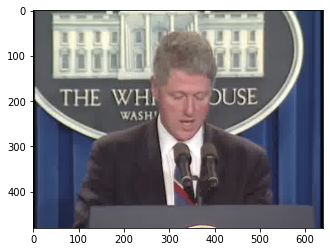

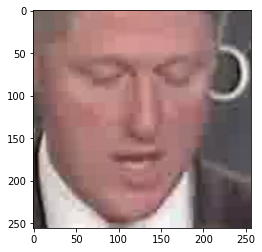

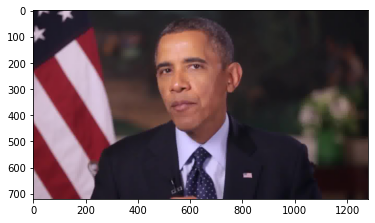

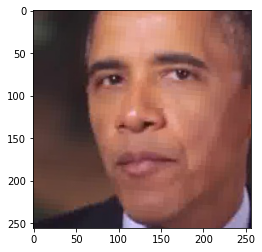

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mp_image

img = mp_image.imread('clinton-jpg/076.jpg')
plt.imshow(img)
plt.show()
img = mp_image.imread('clinton-cut/0760.jpg')
plt.imshow(img)
plt.show()
img = mp_image.imread('obama-jpg/076.jpg')
plt.imshow(img)
plt.show()
img = mp_image.imread('obama-cut/0760.jpg')
plt.imshow(img)
plt.show()

## 학습하기

In [23]:
class dfModel():
    def __init__(self):

        self.model_dir = sav_Model
        self.pretrained_weight=pretrained_weight
        self.encoder = self.Encoder()
        self.decoder_A = self.Decoder()
        self.decoder_B = self.Decoder()

        self.initModel()


    def initModel(self):
        optimizer = Adam(lr=5e-5, beta_1=0.5, beta_2=0.999) #orig adam 5e-5
        x = Input(shape=IMAGE_SHAPE)

        self.autoencoder_A = KerasModel(x, self.decoder_A(self.encoder(x)))
        self.autoencoder_B = KerasModel(x, self.decoder_B(self.encoder(x)))
        print(self.encoder.summary())
        print(self.decoder_A.summary())


        self.autoencoder_A.compile(optimizer=optimizer, loss='mean_absolute_error')
        self.autoencoder_B.compile(optimizer=optimizer, loss='mean_absolute_error')

    def converter(self, swap):
        autoencoder = self.autoencoder_B if not swap else self.autoencoder_A
        return lambda img: autoencoder.predict(img)

    def conv(self, filters):
        def block(x):
            x = Conv2D(filters, kernel_size=5, strides=2, padding='same')(x)
            x = LeakyReLU(0.1)(x)
            return x
        return block

    def upscale(self, filters):
        def block(x):
            x = Conv2D(filters * 4, kernel_size=3, padding='same')(x)
            x = LeakyReLU(0.1)(x)
            x = PixelShuffler()(x)
            #Pixelshufflers job here is analoguous to upsampling2d
            return x
        return block

    #Note how no maxpooling after every layer here, we are generating a WARPED image, not a lower dimensional representation first.
    def Encoder(self):
        input_ = Input(shape=IMAGE_SHAPE)
        x = input_
        x = self.conv(128)(x)
        x = self.conv(256)(x)
        x = self.conv(512)(x)
        x = self.conv(1024)(x)
        x = Dense(ENCODER_DIM)(Flatten()(x))
        x = Dense(4 * 4 * 1024)(x)
        #Passed flattened X input into 2 dense layers, 1024 and 1024*4*4
        x = Reshape((4, 4, 1024))(x)
        #Reshapes X into 4,4,1024
        x = self.upscale(512)(x)
        return KerasModel(input_, x)

    def Decoder(self):
        input_ = Input(shape=(8, 8, 512))
        x = input_
        x = self.upscale(256)(x) #Actually 1024 given filters*4
        x = self.upscale(128)(x) #Actually 512
        x = self.upscale(64)(x) #Actually 256
        x = Conv2D(3, kernel_size=5, padding='same', activation='sigmoid')(x)
        return KerasModel(input_, x)

    def load(self, swapped):
        (face_A,face_B) = (decoder_AH5, decoder_BH5) if not swapped else (decoder_BH5, decoder_AH5)

        try:
            self.encoder.load_weights(self.pretrained_weight + encoderH5)
            self.decoder_A.load_weights(self.pretrained_weight + face_A)
            self.decoder_B.load_weights(self.pretrained_weight + face_B)
            print('loaded model weights')
            return True
        except Exception as e:
            print('Failed loading existing training data.')
            print(e)
            return False

     def save_weights(self):
        self.encoder.save_weights(self.model_dir + encoderH5)
        self.decoder_A.save_weights(self.model_dir + decoder_AH5)
        self.decoder_B.save_weights(self.model_dir + decoder_BH5)
        print('saved model weights')


ls: cannot access 'clinton-cut': No such file or directory


In [ ]:
class Trainer():
    def __init__(self, model, fn_A, fn_B, batch_size=64):
        self.batch_size = batch_size
        self.model = model
        self.images_A = minibatchAB(fn_A, self.batch_size)
        self.images_B = minibatchAB(fn_B, self.batch_size)

    def train_one_step(self, iter):
        epoch, warped_A, target_A = next(self.images_A)
        epoch, warped_B, target_B = next(self.images_B)

        loss_A = self.model.autoencoder_A.train_on_batch(warped_A, target_A)
        loss_B = self.model.autoencoder_B.train_on_batch(warped_B, target_B)
        print("[{0}] [#{1:05d}] loss_A: {2:.5f}, loss_B: {3:.5f}".format(time.strftime("%H:%M:%S"), iter, loss_A, loss_B),
            end='\r')



In [24]:
!ls obama-cut

ls: cannot access 'obama-cut': No such file or directory
